In [9]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow # For showing because cv2.imshow doesn't work normally
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal

In [10]:
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/criminisi_cvpr2003.pdf

In [117]:
test_image = cv2.imread('image2.jpg', cv2.IMREAD_COLOR)
test_mask = cv2.imread('mask2.jpg', cv2.IMREAD_GRAYSCALE)

In [118]:
class inpainting():
    def __init__(self, image, mask, window_size=9):
        assert image.shape[:2] == mask.shape, 'Image and mask must have same shape in 0 and 1 dimensions (HWC)'

        # Original inputs (keeping just in case)
        ######################
        self.original_image = image.astype(np.float32)
        # Image is read in as BGR format, may change to RGB later
        (threshold, self.original_mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        # Mask is binary [0, 255] with 255 inside target, 0 outside
        ######################

        # Values to be updated (not updated when computing priorities but must be updated after)
        ######################
        # Note that self.image and self.mask can be updated

        self.image = np.copy(self.original_image)
        # Image is read in as BGR format, may change to RGB later
        self.mask = np.copy(self.original_mask)
        # Mask is binary [0, 255] with 255 inside target, 0 outside
        # 1 at edges, 0 otherwise
        self.fill_front = cv2.Canny(self.mask, 0, 255) / 255
        # 0 inside target, 1 outside target
        self.inv_mask = 1 - (np.copy(self.mask) / 255)
        self.C = np.copy(self.inv_mask)  # 0 inside target, 1 outside target
        ######################

        # Constant Scalars
        ######################
        self.window_size = window_size
        # Enforce must be odd and positive
        assert self.window_size % 2 != 0 and self.window_size > 0, 'Window size must be odd and positive'
        # Default size in paper is 9 "but in practice require the user to set it to be slightly larger than the largest texture element"
        self.alpha = 255
        # self.window_area = np.square(self.window_size)
        self.window_k = (self.window_size - 1) // 2  # Half of the window
        self.image_height, self.image_width = self.mask.shape
        ######################

        # Constant Kernels
        ######################
        self.sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        self.sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        # For calculating normal of target edge
        self.simple_grad_kernel_x = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
        # For calculating normal of target edge
        self.simple_grad_kernel_y = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
        # Used for quick confidences calculation
        self.ones_window = np.ones((self.window_size, self.window_size))
        self.normalization_array = signal.convolve2d(np.ones_like(self.mask), self.ones_window, mode='same', boundary='fill', fillvalue=0)  # Used for quick confidences calculation
        ######################

        # Arrays calculated using the above variables in the compute_priorities() function
        ######################
        self.grad_y = None  # Defined in compute_gradients()
        self.grad_x = None  # Defined in compute_gradients()
        self.edge_normal_y = None  # Defined in compute_normals()
        self.edge_normal_x = None  # Defined in compute_normals()
        self.data = None  # Defined in compute_data()
        self.priorities = None  # Defined in compute_priorities()
        ######################

    # Priority calculation functions
    #################
    def compute_gradients(self):
        # If using lab, have to change this
        grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.grad_y = ndimage.convolve(grayscale_image, self.sobel_y)
        self.grad_x = ndimage.convolve(grayscale_image, self.sobel_x)

    def compute_normals(self):
        # self.inv_mask is same as self.sourceRegion from git repo
        edge_grad_x = ndimage.convolve(self.inv_mask, self.simple_grad_kernel_x)
        edge_grad_y = ndimage.convolve(self.inv_mask, self.simple_grad_kernel_y)
        self.edge_normal_y = -1 * edge_grad_x
        self.edge_normal_x = edge_grad_y
        normal_magnitude = np.sqrt(np.square(self.edge_normal_y) + np.square(self.edge_normal_x))
        # Prevent divide by 0 by not normalizing these elements
        normal_magnitude[normal_magnitude == 0] = 1
        self.edge_normal_y /= normal_magnitude
        self.edge_normal_x /= normal_magnitude

    def compute_data(self):
        self.compute_gradients()
        self.compute_normals()
        data = (self.grad_y * self.edge_normal_y) + (self.grad_x * self.edge_normal_x)
        data = np.abs(data)
        # Possibly not required (repo adds 0.001 to absolute line)
        data[data == 0] = 1e-7
        # data *= self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
        data /= self.alpha
        self.data = data

    def compute_confidences(self):
        unnormalized_confidences = signal.convolve2d(self.C, self.ones_window, mode='same', boundary='fill', fillvalue=0)
        confidences = unnormalized_confidences / self.normalization_array
        # confidences *= self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
        self.C = confidences

    def compute_priorities(self):
        self.compute_data()
        self.compute_confidences()
        # self.fill_front is assumed to be 1 at edges, 0 else
        self.priorities = self.C * self.data * self.fill_front
    #################

    # Filling target patch functions
    #################
    def get_highest_priority_point(self):
        """ Return coordinates for pixel with highest priority value """
        return np.unravel_index(self.priorities.argmax(), self.priorities.shape)

    def get_target_patch(self, p):
        y, x = p
        # TODO: Replace this with a way that allows for variable patch
        if y - self.window_k < 0:
            y_start_diff = self.window_k - y  # Positive, get y_start = y - y_start_diff
        else:
            y_start_diff = self.window_k
        if x - self.window_k < 0:
            x_start_diff = self.window_k - x  # Positive, x_start = x - x_start_diff
        else:
            x_start_diff = self.window_k
        if y + self.window_k + 1 > self.image_height:
            # Positive, y_end = y + y_end_diff
            y_end_diff = self.image_height - (y + 1)
        else:
            y_end_diff = self.window_k + 1
        if x + self.window_k + 1 > self.image_width:
            # Positive, x_end = x + x_end_diff
            x_end_diff = self.image_height - (x + 1)
        else:
            x_end_diff = self.window_k + 1

        # y_start, y_end = max(0, y - self.window_k), min(self.image_height, y + self.window_k + 1) # row top, row bottom
        # x_start, x_end = max(0, x - self.window_k), min(self.image_width, x + self.window_k + 1) # col left, col right
        y_start = y - y_start_diff
        x_start = x - x_start_diff
        y_end = y + y_end_diff
        x_end = x + x_end_diff

        rel_coords = (y_start_diff, y_end_diff, x_start_diff, x_end_diff)

        target_patch = np.copy(self.image[y_start:y_end, x_start:x_end])

        patch_mask = np.copy(self.mask[y_start:y_end, x_start:x_end])
        patch_mask[patch_mask == 255] = 1
        patch_mask = 1 - patch_mask  # Patch mask is 1 in source, 0 in target
        return target_patch, rel_coords, patch_mask

    def find_optimal_source(self, target_patch, rel_coords, patch_mask):
        source_mask = np.copy(self.mask).astype(np.float32)
        source_mask[source_mask == 255] = 1
        source_fill = np.copy(source_mask).astype(np.float32)
        source_mask = 1 - source_mask
        # This stacking is probably inefficient and could be replaced
        source_mask = np.stack([source_mask] * 3, axis=2)
        # source_mask is 0 in target region, 1 in source region
        # Use 500 to indicate if it is in target region or not, just an arbitrary number outside of CIELab range
        source_fill[source_fill == 1] = 500
        source_fill = np.stack([source_fill] * 3, axis=2)
        # source_fill is 500 in target region, 0 in source_region
        source_image = (np.copy(self.image) * source_mask) + source_fill

        patch_mask_3d = np.stack([patch_mask] * 3, axis=2)

        min_score = best_patch_variance = np.inf
        optimal_source_patch = None

        y_start_diff, y_end_diff, x_start_diff, x_end_diff = rel_coords

        for y in range(y_start_diff, self.image_height - y_end_diff):
            for x in range(x_start_diff, self.image_width - x_end_diff):
                y_start = y - y_start_diff
                x_start = x - x_start_diff
                y_end = y + y_end_diff
                x_end = x + x_end_diff

                curr_source_patch = source_image[y_start:y_end,
                                                 x_start:x_end, :]

                if 500 in curr_source_patch:  # Invalid patch; not entirely bound in source region
                    continue
                

                curr_score = np.sum(np.square(curr_source_patch - target_patch) * patch_mask_3d)
                            

                patch_mean = np.zeros(3)
                patch_mask = np.array(patch_mask, dtype=np.bool)

                B = curr_source_patch[:,:,0]
                B = B[patch_mask]
                patch_mean[0] = np.mean(B)
                
                G = curr_source_patch[:,:,1]
                G = G[patch_mask]
                patch_mean[1] = np.mean(G)
               
                R = curr_source_patch[:,:,2]
                R = R[patch_mask]
                patch_mean[2] = np.mean(R)

                inv_patch_mask = np.invert(patch_mask)
                w_mean, w_var = 1, 1
                if curr_score <= min_score:
                    patch_var = 0 
                    B = curr_source_patch[:,:,0]
                    B = B[inv_patch_mask]
                    patch_var += np.sum(np.square(B - patch_mean[0]))
                    G = curr_source_patch[:,:,1]
                    G = G[inv_patch_mask]
                    patch_var += np.sum(np.square(G - patch_mean[1]))
                    R = curr_source_patch[:,:,2]
                    R = R[inv_patch_mask]
                    patch_var += np.sum(np.square(R - patch_mean[2])) 

                    if curr_score < w_mean * min_score or patch_var < w_var * best_patch_variance:
                        best_patch_variance = patch_var
                        min_score = curr_score
                        optimal_source_patch = curr_source_patch
                    

                 
                # if curr_score < min_score:
                #     min_score = curr_score
                #     optimal_source_patch = curr_source_patch

        assert optimal_source_patch is not None, "Source region not found."
        # print(best_patch_variance)
        # print("Best Source Patch: \n", optimal_source_patch[:,:,0])
        # print("Patch mask: \n", patch_mask)
        # print("target patch: \n", target_patch[:,:,0]*patch_mask)
        # print("optimal patch: \n", optimal_source_patch[:,:,0])
        # print("Masked Patch :\n",optimal_source_patch[:,:,0][patch_mask])
        # print("Inv Patch:\n", optimal_source_patch[:,:,0][inv_patch_mask])
        return optimal_source_patch

    def update_image_arrays(self, optimal_source_patch, target_p, rel_coords, patch_mask):
        y, x = target_p

        y_start_diff, y_end_diff, x_start_diff, x_end_diff = rel_coords
        y_start = y - y_start_diff
        x_start = x - x_start_diff
        y_end = y + y_end_diff
        x_end = x + x_end_diff

        # Updating image
        # patch_mask is 0 in target, 1 in source
        # Make target area in image 0
        # Make source area in patch 0
        image_patch_mask = np.stack([patch_mask] * 3, axis=2)
        self.image[y_start:y_end, x_start:x_end, :] = \
            (self.image[y_start:y_end, x_start:x_end, :] * image_patch_mask) + \
            (optimal_source_patch * (1 - image_patch_mask))

        # Updating mask and related arrays
        # Update patch to be source
        # mask is 1 at edges, 0 otherwise
        # inv_mask is 0 inside target, 1 outside target
        self.mask[y_start:y_end, x_start:x_end] = 0
        self.fill_front = cv2.Canny(self.mask, 0, 255) / 255
        self.inv_mask = 1 - (np.copy(self.mask) / 255)

        # Updating C
        # Only update in target region
        C_origin = self.C[y, x] * np.ones_like(patch_mask)
        self.C[y_start:y_end, x_start:x_end] = \
            (self.C[y_start:y_end, x_start:x_end] * patch_mask) + \
            (C_origin * (1 - patch_mask))

    def update_image(self):
        target_p = self.get_highest_priority_point()
        target_patch, rel_coords, patch_mask = self.get_target_patch(target_p)
        optimal_source_patch = self.find_optimal_source(target_patch, rel_coords, patch_mask)
        self.update_image_arrays(optimal_source_patch, target_p, rel_coords, patch_mask)

    def _do_inpainting_single(self):
        self.compute_priorities()
        self.update_image()

    def do_inpainting(self):
        while np.sum(self.fill_front) > 0:
            self._do_inpainting_single()
            cv2_imshow(self.image)  

    #################


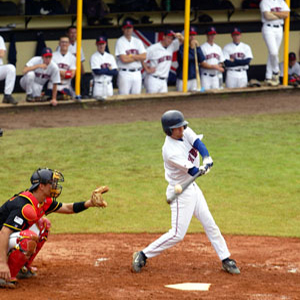

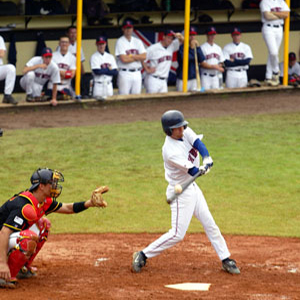

KeyboardInterrupt: ignored

In [120]:
inpainting_obj = inpainting(test_image, test_mask)
inpainting_obj.do_inpainting()
# inpainting_obj._do_inpainting_single()
# inpainting_obj.compute_priorities()
# inpainting_obj.update_image()